In [1]:
from generative.vae import VAE
from generative.train import train_vae

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch 
import torch.nn as nn
import torch.optim as optim

In [2]:
## First let's load the training data
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
import pandas as pd

ROOT_PATH = Path("train/")
training_data = [(np.load(ROOT_PATH / f"data_{i}.npy"),np.load(ROOT_PATH / f"target_{i}.npy")) for i in range(4)]

In [3]:
# Let's filter the signal to improve the visualisation

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [4]:
# First we need to get the point that maps to a label

def reshape_array_into_windows(x, sample_rate, window_duration_in_seconds):
    """
    Reshape the data into an array of shape (C, T, window) where 'window' contains
    the points corresponding to 'window_duration' seconds of data.

    Parameters:
    x (numpy array): The input data array.
    sample_rate (int): The number of samples per second.
    window_duration_in_seconds (float): The duration of each window in seconds.

    Returns:
    reshaped_x (numpy array): The reshaped array with shape (C, T, window).
    """
    # Calculate the number of samples in one window
    window_size = int(window_duration_in_seconds * sample_rate)
    
    # Ensure the total length of x is a multiple of window_size
    total_samples = x.shape[-1]
    if total_samples % window_size != 0:
        # Truncate or pad x to make it divisible by window_size
        x = x[..., :total_samples - (total_samples % window_size)]
    # Reshape x into (C, T, window)
    reshaped_x = x.reshape(x.shape[0], -1, window_size)

    return reshaped_x


In [5]:
# We first load and reshape all the data
all_data = []
all_targets = []
for (data,target) in training_data:
    filtered_data =  butter_bandpass_filter(data,0.1,18,250,4)
    reshaped_data = reshape_array_into_windows(filtered_data,250,2)
    targets_flatten = target[..., :len(reshaped_data[0])].reshape(-1)
    reshaped_data = reshaped_data.reshape((-1,reshaped_data.shape[-1]))
    all_data.append(reshaped_data)
    all_targets.append(targets_flatten)
all_data = np.concatenate(all_data)
all_targets = np.concatenate(all_targets)
assert all_data.shape[0] == all_targets.shape[0]

In [6]:
scaler = StandardScaler()
all_data = scaler.fit_transform(all_data)

In [7]:
all_data = torch.tensor(all_data).float()

In [8]:
vae_gen = VAE(input_dim=all_data.shape[-1],hidden_dim=16, latent_dim=15)

In [9]:
vae_gen.to("cuda")

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=500, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=30, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=500, bias=True)
  )
)

In [10]:
optimizer = optim.Adam(vae_gen.parameters(), lr=1e-3)

In [11]:
vae_gen(all_data[1].to("cuda"))

(tensor([-0.2657, -0.2546, -0.3913,  0.1044,  0.1012, -0.1308,  0.2646,  0.0169,
         -0.0185,  0.0794,  0.4935,  0.2329,  0.0954, -0.0008,  0.2236,  0.2216,
         -0.1024, -0.1666, -0.3684, -0.1943, -0.6006, -0.0518, -0.4812,  0.2977,
         -0.5214, -0.0956,  0.4204, -0.2250,  0.0619, -0.0760, -0.1071,  0.0142,
         -0.3607, -0.0575, -0.1899, -0.0606, -0.1742,  0.0520, -0.1393, -0.3690,
         -0.3551,  0.0226,  0.4154,  0.2854,  0.1325,  0.2773,  0.0102,  0.1734,
         -0.3223, -0.1526, -0.0335,  0.0611,  0.0407, -0.2573, -0.0658,  0.2472,
         -0.1021, -0.0264,  0.3411, -0.0536,  0.1410,  0.1535,  0.0957, -0.0925,
         -0.1577, -0.3701, -0.1352,  0.1192, -0.0895, -0.2940, -0.0853,  0.0065,
         -0.0886, -0.2470, -0.0073,  0.5660,  0.2290, -0.0171,  0.2216, -0.5496,
          0.2103,  0.3865, -0.2047,  0.1173,  0.0372,  0.1253,  0.2233,  0.0654,
          0.2010,  0.1190,  0.0227,  0.0914, -0.1032, -0.0695, -0.0623,  0.1213,
         -0.2581,  0.2448, -

In [36]:
train_data = all_data[1000:10000].to("cuda")

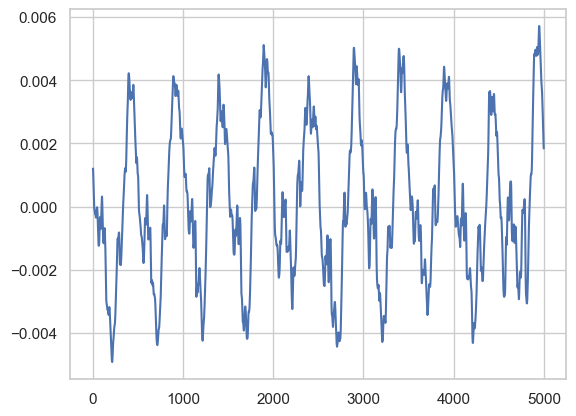

In [57]:
# Plot part of the data
data = np.concatenate(train_data[0:10].cpu().numpy())
plt.plot(data)
plt.show()


In [37]:
train_vae(train_data, vae_gen, optimizer, num_epochs=5)

Epoch 0, Loss: 0.0166
Epoch 1, Loss: 0.0168
Epoch 2, Loss: 0.0168
Epoch 3, Loss: 0.0167
Epoch 4, Loss: 0.0167


In [40]:
# study the latent space
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

def plot_latent_space(vae, data, targets):
    with torch.no_grad():
        mu, logvar = vae.encode(data.to("cuda"))
        z = vae.reparameterize(mu, logvar).cpu().numpy()
    z_embedded = TSNE(n_components=2).fit_transform(z)
    df = pd.DataFrame(z_embedded, columns=["x", "y"])
    df["targets"] = targets
    sns.scatterplot(data=df, x="x", y="y", hue="targets")
    plt.show()
    

In [41]:
plot_latent_space(vae_gen, train_data, all_targets[:1000])

KeyboardInterrupt: 

In [28]:
# Let's try to generate some data
def generate_data(vae, n_samples):
    with torch.no_grad():
        z = torch.randn(n_samples, 15).to("cuda")
        generated_data = vae.generate(z).cpu().numpy()
    return generated_data

In [49]:
eeg = generate_data(vae_gen, 1)

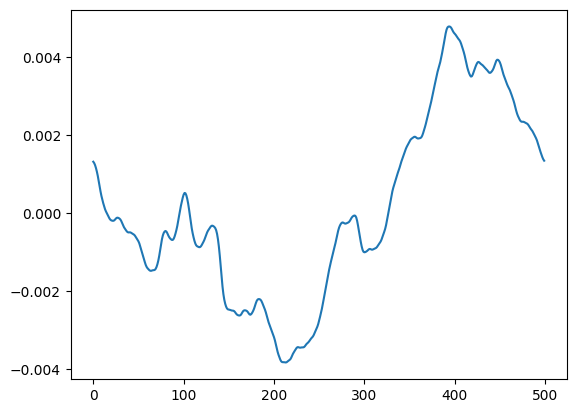

In [50]:
# Let's plot the generated data
plt.plot(eeg[0])
plt.show()

In [42]:
# Check the reconstruction quality

def plot_reconstruction(vae, data):
    with torch.no_grad():
        mu, logvar = vae.encode(data.to("cuda"))
        reconstructed_data = vae.generate(mu).cpu().numpy()
    plt.plot(data.cpu().numpy()[0], label="Original")
    plt.plot(reconstructed_data[0], label="Reconstructed")
    plt.legend()
    plt.show()


In [46]:
train_data.shape

torch.Size([9000, 500])